# ニューラルネットワークによる関数近似

## このファイルについて
ニューラルネットワークをNumpyにより実装し，関数近似を行ってみる．

## ライブラリのimport

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random
from tqdm import tqdm

## 近似する関数
* このファイルでは1入力，1出力の関数と，2入力1出力の関数を近似する．
* 近似した関数を視覚化してみて差を定性的に評価したいので，入力値を一定感覚に区切る．2入力1出力関数は入力が格子点になる．
* 1入力1出力関数
    * 線形関数
    * 正規分布
* 2入力1出力
    * 線形関数
    * y = sinx_1 + cosx_2 + const
    * y = (x_1)^2 - x_1 + const

### 1入力1出力
以下の2種類の関数を用意しておく．
* 線形関数
* 非線形関数(正規分布をy方向に平行移動したもの)

In [51]:
# 入力する値
x = np.arange(-10, 10, 0.1)
print(x.shape)

(200,)


In [52]:
# 結果を表示するための関数
def plot_2d(x, t, y=None):
    """
    x: 入力値1次元numpy配列
    t: 近似したい値(教師データ)
    y: モデルの推論結果
    """
    plt.scatter(x, t, label='target', color='red')
    if y is not None:
        plt.scatter(x, y, label='predict')
    
    plt.grid()
    plt.legend()
    plt.show()

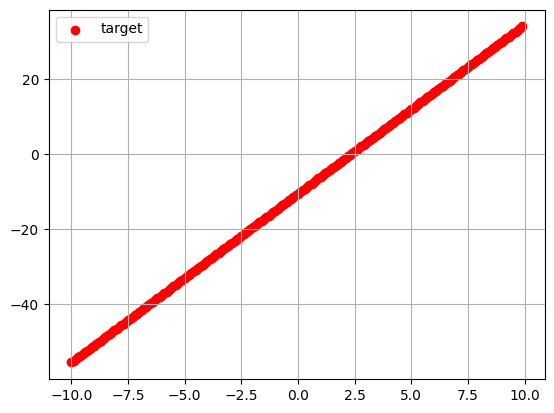

In [53]:
# 1入力1出力の線形関数
def single_linear_func(x:np.ndarray)->np.ndarray:
    """
    x: 1次元のnumpy配列
    return: 1次元のnumpy 配列
    """
    return 4.5*x - 10.5
plot_2d(x, single_linear_func(x))

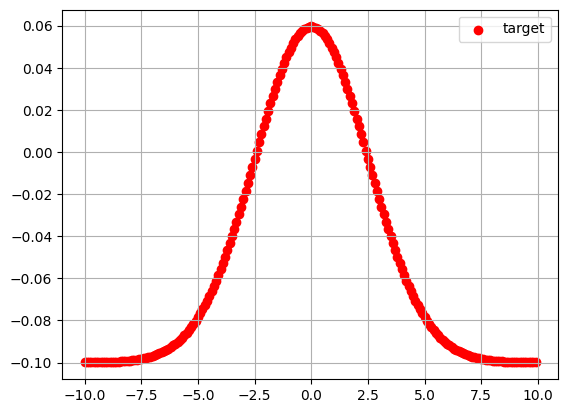

In [54]:
def single_non_linear_func(x:np.ndarray)->np.ndarray:
    """
    1入力1出力の非線形関数
    x: 1次元のnumpy配列
    return: 正規分布を負の値も取るように平行移動させた値
    """
    mean = 0
    sigma = 2.5
    bias = 0.1

    return (1/np.sqrt(2*np.pi*np.square(sigma)))*np.exp(-(x*x-mean)/(2*np.square(sigma))) - bias

plot_2d(x, single_non_linear_func(x))

### 2入力1出力
* 線形関数
* 非線形関数

In [55]:
# 入力する値
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

In [56]:
def plot_3d(X_1, X_2, Y):
    """
    X_1, X_2: 入力となる2次元numpy配列
    Y: X_1, X_2に対応する出力値の2次元numpy配列
    """
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    ax.plot_surface(X_1, X_2, Y, rstride=1, cstride=10, cmap='jet', alpha=0.4)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

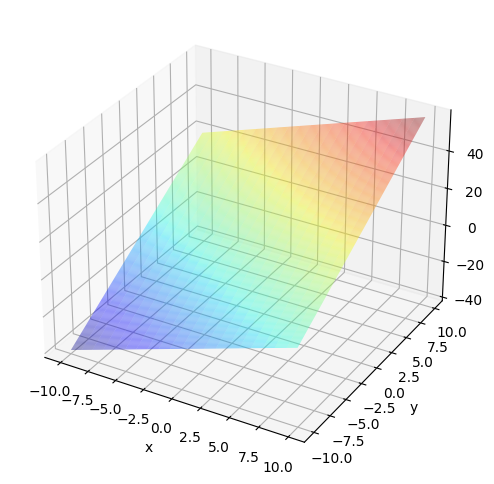

In [57]:
def double_linear_func(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
    """
    2入力1出力の線形関数
    x_1, x_2: 入力(2次元配列でも次元数が一致していれば可)
    return: 成分ごとに独立して非線形関数をかました関数
    """
    return 2*x_1 + 3*x_2 + 10

plot_3d(X_1, X_2, double_linear_func(X_1, X_2))

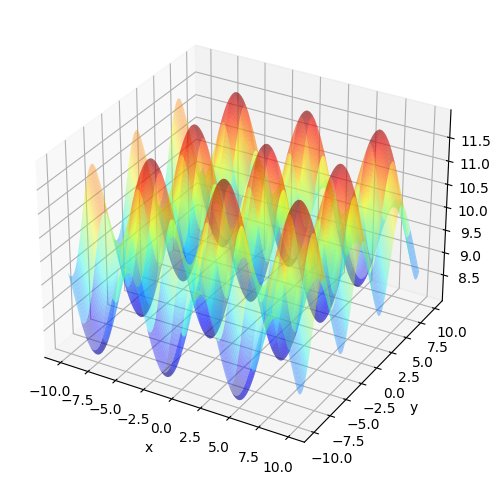

In [58]:
def double_non_linear_func(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
    """
    2入力1出力の線形関数
    x_1, x_2: 入力(2次元配列でも次元数が一致していれば可)
    return: 成分ごとに独立して非線形関数をかました関数
    """
    
    return np.sin(x_1) + np.cos(x_2) + 10

plot_3d(X_1, X_2, double_non_linear_func(X_1, X_2))

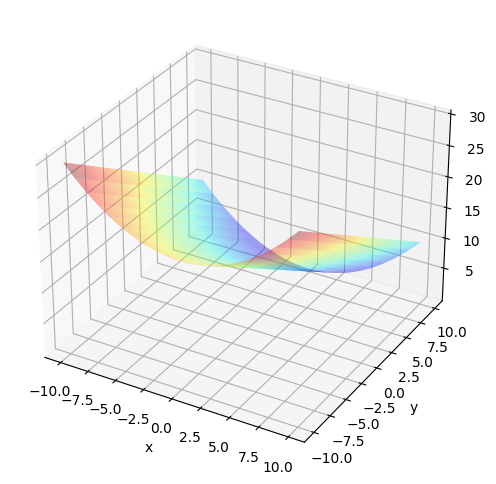

In [59]:
def double_non_linear_func_2(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
    """
    2入力1出力の線形関数
    x_1, x_2: 入力(2次元配列でも次元数が一致していれば可)
    return: 成分ごとに独立して非線形関数をかました関数
    """
    
    return 0.1*x_1*x_1 - x_2  + 10

plot_3d(X_1, X_2, double_non_linear_func_2(X_1, X_2))

## ニューラルネットワークの実装
numpyでニューラルネットワークを実装する．層単位でクラスを作成し，それぞれのクラスには以下のメソッドを持たせる．
入力は(バッチ, データの次元)の2次元行列を想定
* forward: 入力値を順伝播する
* backward: 勾配を逆伝播する
* update: learning rateを受け取りパラメータを更新する

In [60]:
class BaseLayer:
    def forward(self):
        raise NotImplementedError("Subclass must implement this method")
    
    def forward(self):
        raise NotImplementedError("Subclass must implement this method")
    
    def update(self):
        raise NotImplementedError("Subclass must implement this method")

In [61]:
class LinearLayer(BaseLayer):
    def __init__(self, hidden_input, hidden_output):
        self.W = random((hidden_input, hidden_output))
        self.B = random(hidden_output)
        self.X = None

        self.dW = None
        self.dB = None

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        self.X = X
        Y = np.dot(self.X, self.W) + self.B
        return Y
    
    def backward(self, dY):
        self.dW = np.dot(self.X.T, dY)
        self.dX = np.dot(dY, self.W.T)
        self.dB = np.sum(dY, axis=0)
        return self.dX
    
    def update(self, lr):
        self.W -= lr*self.dW
        self.B -= lr*self.dB

In [62]:
class MSELayer(BaseLayer):
    def __call__(self, Y, T):
        return self.forward(Y,T)

    def forward(self, Y, T):
        self.Y = Y
        self.T = T
        loss = np.mean(((Y-T)**2)/2)
        return loss
    
    def backward(self):
        batch = self.Y.shape[0]
        d_mse = (self.Y - self.T)/batch
        return d_mse
    
    def update(self, lr):
        pass

In [63]:
class ReLULayer(BaseLayer):
    def __init__(self):
        pass

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        self.X = X
        return np.maximum(self.X, 0)
    
    def backward(self, dY):
        dX = dY*(self.X > 0).astype(np.float64)  # ReLU関数の勾配を計算
        return dX
    
    def update(self, lr):
        pass

In [64]:
class Model:
    def __init__(self, layers:list, loss_layer):
        self.layers = layers
        self.loss_layer = loss_layer

    def __call__(self, X, T):
        return self.forward(X, T)

    def forward(self, X, T):
        # 全ての層に入力を通してlossを返す
        self.X = X
        self.T = T
        for layer in self.layers:
            self.X = layer(self.X)
        loss = self.loss_layer(self.X, self.T)
        return loss
    
    def backward(self):
        reversed_layers = self.layers[::-1]

        dout = self.loss_layer.backward()

        for layer in reversed_layers:
            dout = layer.backward(dout)
        
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    def predict(self, X):
        self.X = X
        for layer in self.layers:
            self.X = layer(self.X)
        return self.X

## 学習に用いるクラス設計
* DataLoader: データセットをミニバッチ単位に分割する
* Trainer: 学習の過程や結果などを出力
* plot_history: 学習過程のlossを出力する

In [65]:
class DataLoader:
    def __init__(self, dataset:tuple, batch_size:int):
        """
        イテレーションごとにミニバッチを出力するdataloader
        中途半端なインデックスのデータは捨てる
        dataset: (入力テンソル, 教師テンソル)のtuple
        入力テンソル: (データ数, データ次元)
        教師テンソル: (データ数, データ次元)
        batch_size: ミニバッチサイズ
        """
        self.batch_size = batch_size
        self.batch_num = int(dataset[0].shape[0]/batch_size)  # mini batch数
        self.cut_input = dataset[0][:self.batch_num*batch_size] 
        self.cut_target = dataset[1][:self.batch_num*batch_size] 

    def __iter__(self):
        self.batch_counter = 0  # 何バッチ目まで出力したかを格納
        return self
    
    def __next__(self):
        if self.batch_counter == self.batch_num:
            raise StopIteration
        start = self.batch_counter*self.batch_size
        end = (self.batch_counter+1)*self.batch_size
        minibatch_input = self.cut_input[start:end]
        minibatch_target = self.cut_target[start:end]
        self.batch_counter += 1
        return minibatch_input, minibatch_target

In [66]:
T = double_non_linear_func(X_1, X_2)
def make_dataset(X_1:np.ndarray, T:np.ndarray, X_2=None)->tuple:
    """
    2つの入力の説明変数numpy配列と1つの目的変数numpy配列を受け取り
    (入力np.array, 教師np.array)を返す
    input
    X_1, X_2: 
    2次元(1次元)numpy配列
    np.meshgrid で作成した2次元配列にも対応できる
    T:
    2次元(1次元)numpy配列
    目的変数
    return
    (入力np.array, 教師np.array)それぞれ2次元np.array
    """
    if X_2 is None:
        # 説明変数が1次元の場合
        X = X_1.reshape(-1,1)
        
    else:
        # 説明変数が2次元の場合
        X = np.array([(i,j) for i,j in zip(X_1.reshape(-1), X_2.reshape(-1))])
        
    dataset = (X, T.reshape(-1,1))
    return dataset
dataset = make_dataset(X_1, T, X_2)

In [67]:
class Trainer:
    def __init__(self, model, dataloader, epochs=1000, lr=0.001):
        self.model = model
        self.dataloader = dataloader
        self.epochs = epochs
        self.lr = lr
        self.history = []  # 学習時の損失を記録するlist

    def train(self):
        for epoch in range(0, self.epochs):
            print(f"----------epoch: {epoch+1} start----------")
            loss = 0
            iter_counter = 0
            for batch in self.dataloader:
                X = batch[0]
                T = batch[1]
                loss += self.model(X, T)
                self.model.backward()
                self.model.update(self.lr)

                iter_counter += 1
            self.history.append(loss/iter_counter)
            print(self.history[-1])
    
    def get_model(self):
        return self.model
    
    def get_history(self)->list:
        return self.history

In [68]:
def plot_history(history):
    plt.plot(history, marker="o")
    plt.xlabel("epoch")
    plt.ylabel("MSE Loss")
    plt.ylim(bottom=0)
    plt.show()

## 実際に近似してみる

### 1入力1出力の近似
1層のNNと2層異常のNNで線形関数と非線形関数をそれぞれ近似してみる．1層NNは，線形関数なので非線形関数をうまく近似できないが，非線形関数は線形関数を近似できると予想．
* 線形関数の線形近似
* 非線形関数の線形近似
* 線形関数の非線形近似
* 非線形関数の非線形近似

----------epoch: 1 start----------
177.49210933411297
----------epoch: 2 start----------
86.82809816422632
----------epoch: 3 start----------
65.04111210751108
----------epoch: 4 start----------
57.530428335898996
----------epoch: 5 start----------
53.44354205384824
----------epoch: 6 start----------
50.389398597022435
----------epoch: 7 start----------
47.75193717296812
----------epoch: 8 start----------
45.34041377397532
----------epoch: 9 start----------
43.08474741224175
----------epoch: 10 start----------
40.95496189238003
----------epoch: 11 start----------
38.9360224513666
----------epoch: 12 start----------
37.01889310324489
----------epoch: 13 start----------
35.19709890566392
----------epoch: 14 start----------
33.46534708241374
----------epoch: 15 start----------
31.81895980598915
----------epoch: 16 start----------
30.25363533710405
----------epoch: 17 start----------
28.765343715676405
----------epoch: 18 start----------
27.350278037381745
----------epoch: 19 start--------

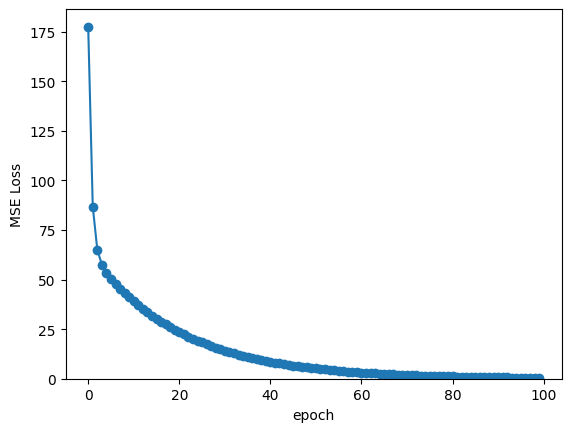

In [69]:
# 線形関数の線形近似
x = np.arange(-10, 10, 0.1)
t = single_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=100)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

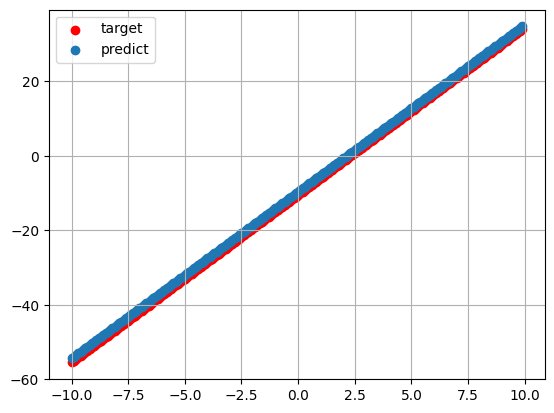

In [70]:
test = trained_model.predict(x.reshape(-1,1))
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

----------epoch: 1 start----------
8.231520703353747
----------epoch: 2 start----------
1.5613657544449366
----------epoch: 3 start----------
0.4215123742701753
----------epoch: 4 start----------
0.2346586509197283
----------epoch: 5 start----------
0.2034060392490813
----------epoch: 6 start----------
0.19405779960741742
----------epoch: 7 start----------
0.18640212236170176
----------epoch: 8 start----------
0.17834650230888588
----------epoch: 9 start----------
0.17013594117414377
----------epoch: 10 start----------
0.16206012977458312
----------epoch: 11 start----------
0.1542628324710682
----------epoch: 12 start----------
0.1467985599443097
----------epoch: 13 start----------
0.13968020838279255
----------epoch: 14 start----------
0.13290305956923237
----------epoch: 15 start----------
0.1264554502405949
----------epoch: 16 start----------
0.12032329585909755
----------epoch: 17 start----------
0.11449196161351917
----------epoch: 18 start----------
0.10894701777504365
----------

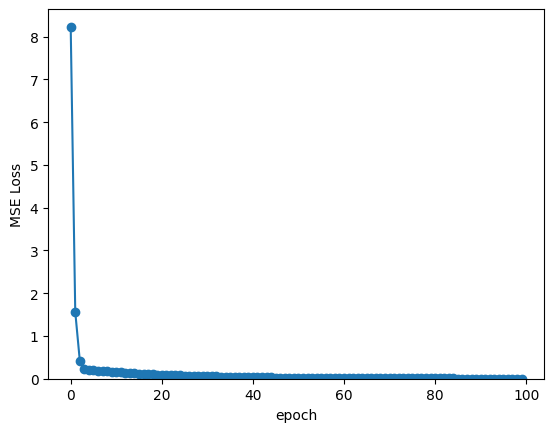

In [71]:
# 非線形関数の線形近似
x = np.arange(-10, 10, 0.1)
t = single_non_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=100)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

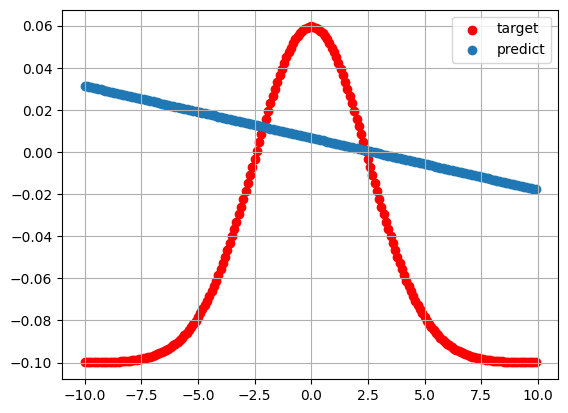

In [72]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

(200,)
(200,)
----------epoch: 1 start----------
349.1732248358171
----------epoch: 2 start----------
332.7088711680952
----------epoch: 3 start----------
324.1258951494169
----------epoch: 4 start----------
315.9824634779924
----------epoch: 5 start----------
308.13078981872604
----------epoch: 6 start----------
300.5511967685803
----------epoch: 7 start----------
293.22789807325535
----------epoch: 8 start----------
286.1498534539626
----------epoch: 9 start----------
279.3037364317989
----------epoch: 10 start----------
272.6817572001873
----------epoch: 11 start----------
266.2759623183522
----------epoch: 12 start----------
260.07814488855206
----------epoch: 13 start----------
254.07989590346725
----------epoch: 14 start----------
248.27454043663835
----------epoch: 15 start----------
242.65531656912106
----------epoch: 16 start----------
237.21554146864656
----------epoch: 17 start----------
231.94823320226212
----------epoch: 18 start----------
226.8472704366544
----------epoch

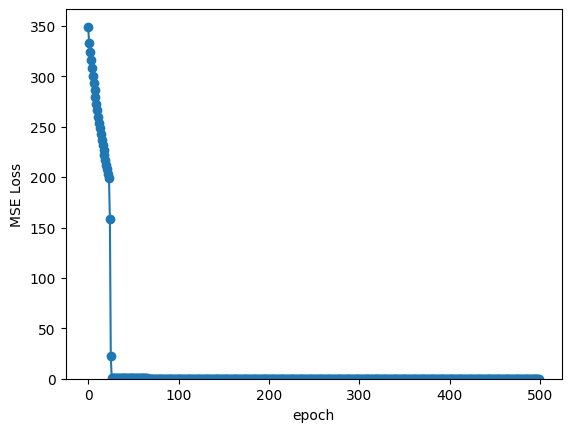

In [73]:
# 線形関数の非線形近似
x = np.arange(-10, 10, 0.1)
t = single_linear_func(x)
print(x.shape)
print(t.shape)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,16),
    ReLULayer(),
    LinearLayer(16,1)
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=500)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

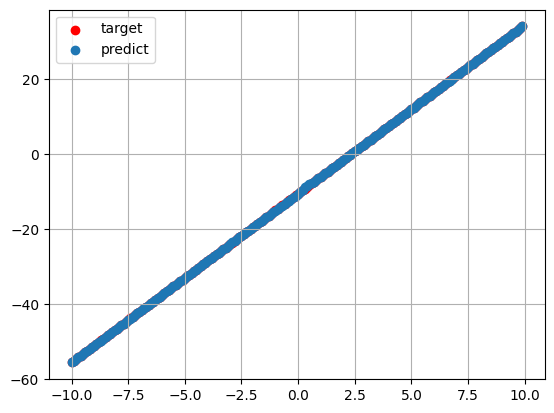

In [74]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

----------epoch: 1 start----------
3179.3843418597726
----------epoch: 2 start----------
232.32590586752806
----------epoch: 3 start----------
36.49837331831198
----------epoch: 4 start----------
6.576620720133167
----------epoch: 5 start----------
1.4834333117272869
----------epoch: 6 start----------
0.5682095730694857
----------epoch: 7 start----------
0.38944851203274006
----------epoch: 8 start----------
0.3486851534535383
----------epoch: 9 start----------
0.33678357062503644
----------epoch: 10 start----------
0.33202829705231024
----------epoch: 11 start----------
0.3294153552924483
----------epoch: 12 start----------
0.3275531749898284
----------epoch: 13 start----------
0.32598232300488644
----------epoch: 14 start----------
0.324532456238232
----------epoch: 15 start----------
0.32313695036883744
----------epoch: 16 start----------
0.32176900400806013
----------epoch: 17 start----------
0.32041822329801944
----------epoch: 18 start----------
0.3190793093908995
----------epoch

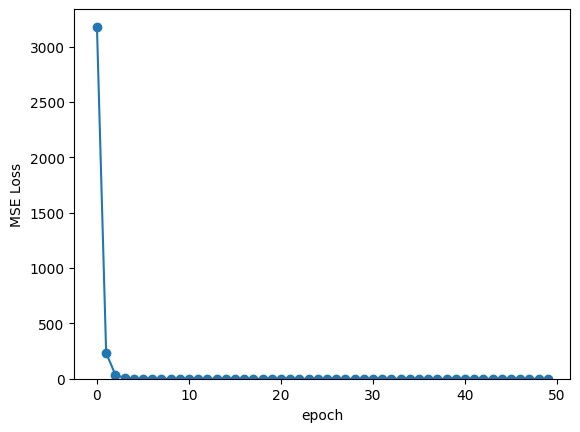

In [113]:
# 非線形関数の非線形近似
x = np.arange(-10, 10, 0.1)
t = single_non_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,16),
    ReLULayer(),
    LinearLayer(16,16),
    ReLULayer(),
    LinearLayer(16,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=50, lr=0.00001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

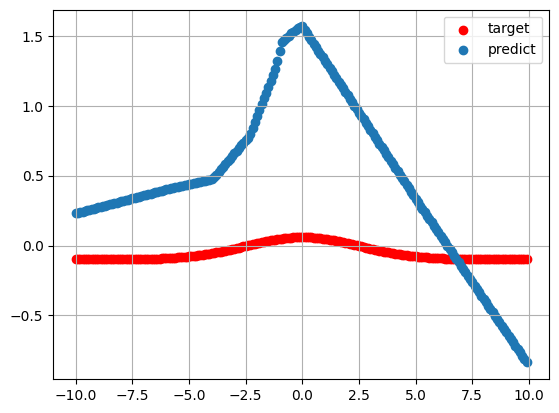

In [114]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

### 2入力1出力の近似
* 線形関数の線形近似
* 非線形関数の線形近似
* 線形関数の非線形近似
* 非線形関数の非線形近似

----------epoch: 1 start----------
23.3963296417276
----------epoch: 2 start----------
13.969108785295749
----------epoch: 3 start----------
8.91770270978215
----------epoch: 4 start----------
5.692944385756142
----------epoch: 5 start----------
3.634300989167786
----------epoch: 6 start----------
2.320090059708453
----------epoch: 7 start----------
1.481115048313763
----------epoch: 8 start----------
0.9455244106416443
----------epoch: 9 start----------
0.6036103759374004
----------epoch: 10 start----------
0.3853369430114143


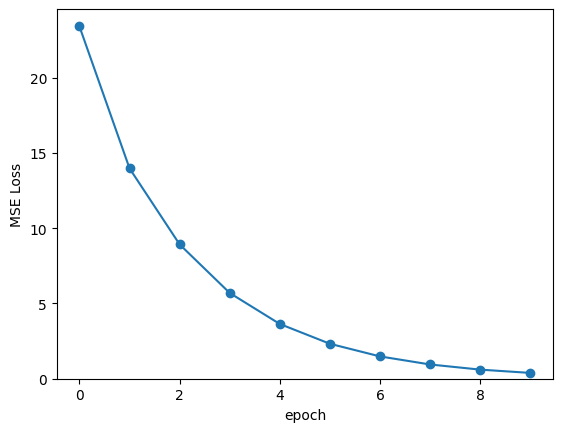

In [77]:
# 線形関数の線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

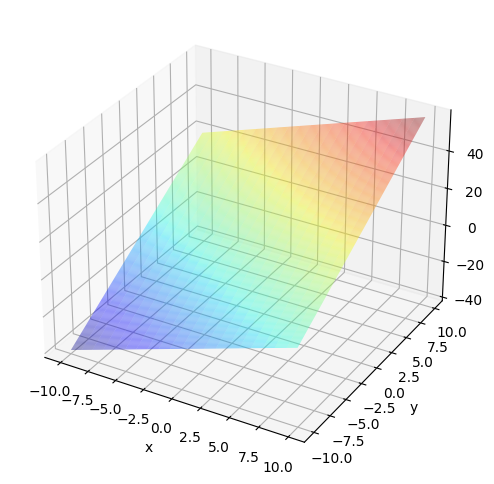

In [78]:
plot_3d(X_1, X_2,T)

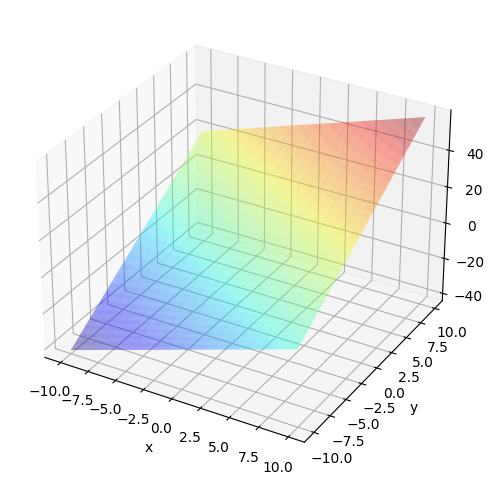

In [79]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
18.48242486470551
----------epoch: 2 start----------
12.664797732709708
----------epoch: 3 start----------
8.2313505074455
----------epoch: 4 start----------
5.4021930707634835
----------epoch: 5 start----------
3.5969733539257875
----------epoch: 6 start----------
2.445245702689221
----------epoch: 7 start----------
1.7105579181088895
----------epoch: 8 start----------
1.2419903398939933
----------epoch: 9 start----------
0.9432204653175866
----------epoch: 10 start----------
0.752775352166007


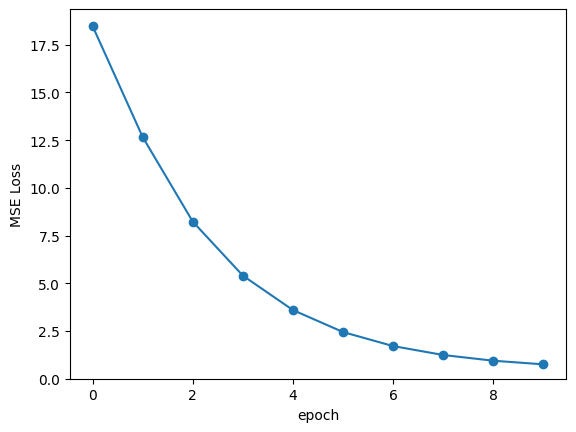

In [80]:
# 非線形関数の線形近似
# 線形関数の線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

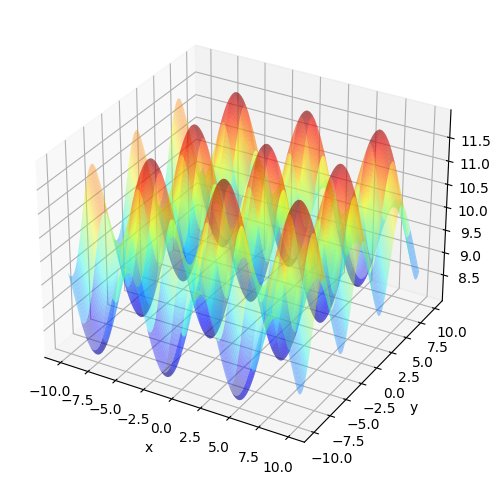

In [81]:
plot_3d(X_1, X_2,T)

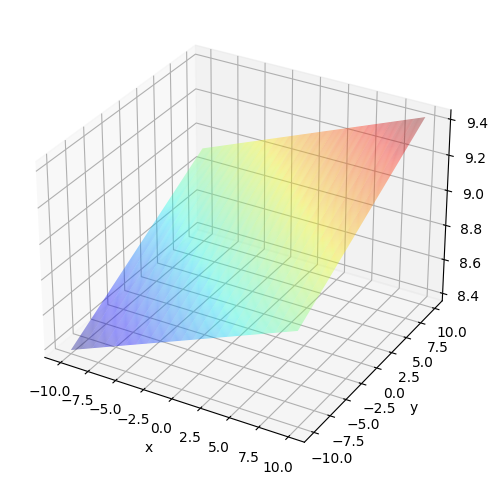

In [82]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
47.85692838828505
----------epoch: 2 start----------
18.586888058355587
----------epoch: 3 start----------
1.825663100927384
----------epoch: 4 start----------
1.4042790299547898
----------epoch: 5 start----------
0.8662796952300177
----------epoch: 6 start----------
0.5469930408722671
----------epoch: 7 start----------
0.37127694548743173
----------epoch: 8 start----------
0.26890065838119204
----------epoch: 9 start----------
0.20177574744710333
----------epoch: 10 start----------
0.15496452024309412


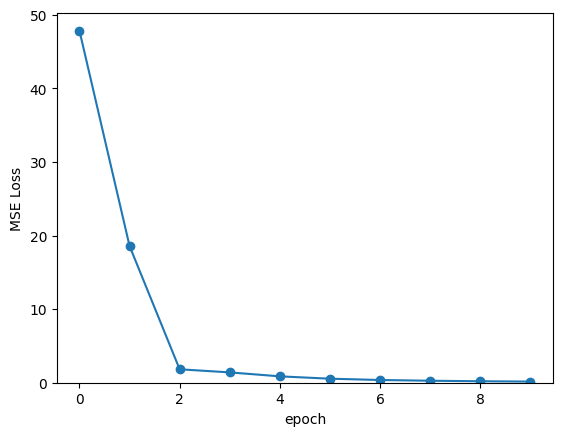

In [83]:
# 線形関数の非線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,16),
    ReLULayer(),
    LinearLayer(16,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

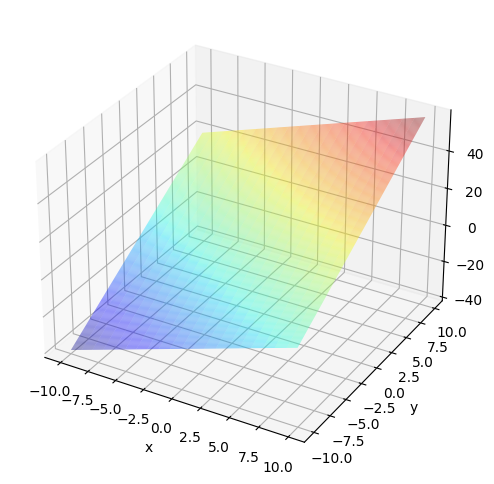

In [84]:
plot_3d(X_1, X_2,T)

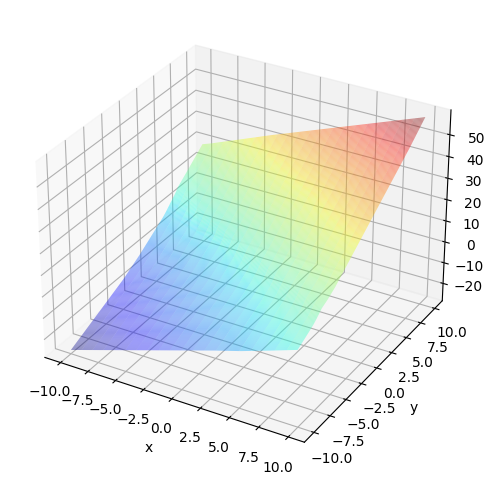

In [85]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
1.8331754675590062
----------epoch: 2 start----------
0.7334073334346556
----------epoch: 3 start----------
0.7447514135014414
----------epoch: 4 start----------
0.3991243698948962
----------epoch: 5 start----------
0.35329016137152747
----------epoch: 6 start----------
0.28661097294718557
----------epoch: 7 start----------
0.26473536109268503
----------epoch: 8 start----------
0.26160938727991134
----------epoch: 9 start----------
0.2603760192937002
----------epoch: 10 start----------
0.2573375687970946
----------epoch: 11 start----------
0.2520019692559502
----------epoch: 12 start----------
0.2493144390519417
----------epoch: 13 start----------
0.24556012391964757
----------epoch: 14 start----------
0.23903466719911423
----------epoch: 15 start----------
0.23659187588554878
----------epoch: 16 start----------
0.23331018554710736
----------epoch: 17 start----------
0.2308814773547473
----------epoch: 18 start----------
0.22157679867015173
----------

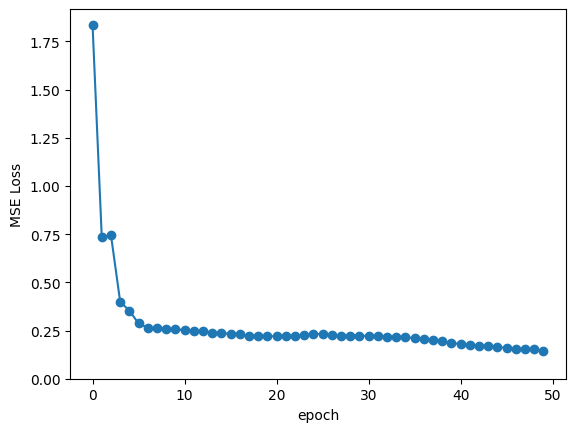

In [86]:
# 非線形関数の非線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,64),
    ReLULayer(),
    LinearLayer(64,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=50, lr=0.001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

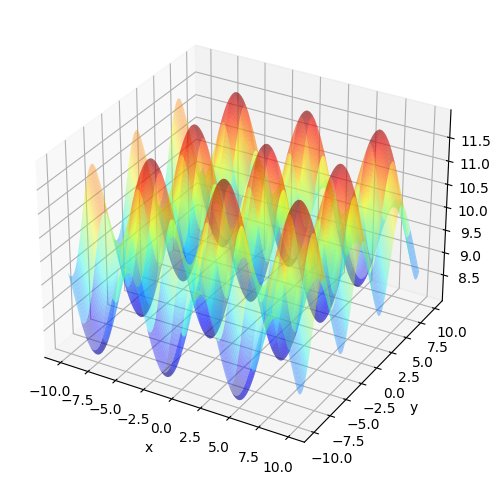

In [87]:
plot_3d(X_1, X_2,T)

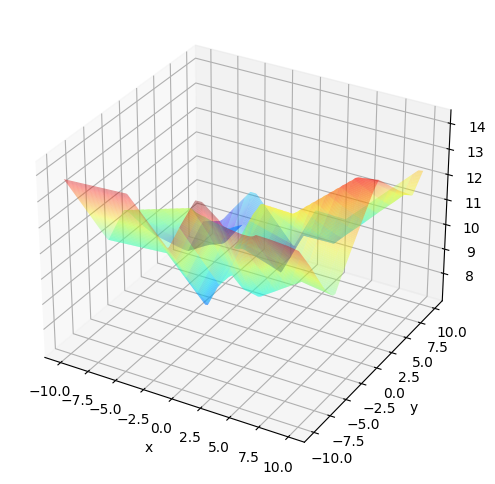

In [88]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
5.308886244081213
----------epoch: 2 start----------
0.5613160315394339
----------epoch: 3 start----------
0.5839962227789511
----------epoch: 4 start----------
0.10188788190193776
----------epoch: 5 start----------
0.07363586153934434
----------epoch: 6 start----------
0.06515327268669184
----------epoch: 7 start----------
0.06901170000951147
----------epoch: 8 start----------
0.06647600666008714
----------epoch: 9 start----------
0.05337889776686641
----------epoch: 10 start----------
0.05859557165246669
----------epoch: 11 start----------
0.043539506095358775
----------epoch: 12 start----------
0.05047511118687976
----------epoch: 13 start----------
0.05955468752826715
----------epoch: 14 start----------
0.054608064816738223
----------epoch: 15 start----------
0.04703039097335531
----------epoch: 16 start----------
0.04320370169173322
----------epoch: 17 start----------
0.040131666506160776
----------epoch: 18 start----------
0.03901902920112141
--

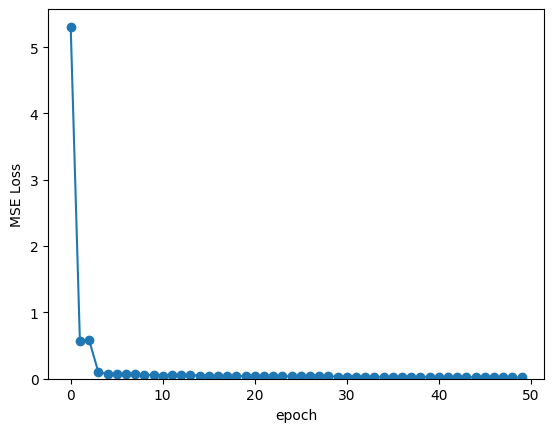

In [90]:
# 非線形関数の非線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func_2(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,64),
    ReLULayer(),
    LinearLayer(64,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=50, lr=0.001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

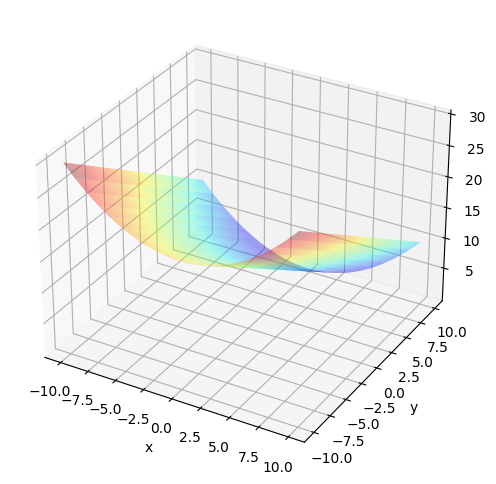

In [92]:
plot_3d(X_1, X_2,T)

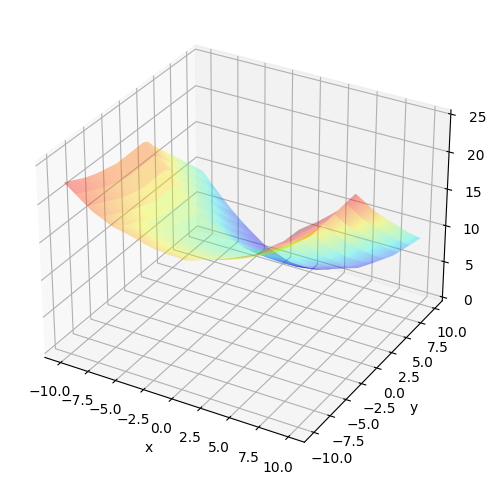

In [91]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

## 結果・結論
* 1入力1出力
    * 線形関数の1層NNによる近似  
        関数の形をNN で再現できた．
    * 非線形関数の1層NNによる近似  
        1層NNでは線形関数しか再現できないことを視覚的に確認できた．
    * 線形関数の2層以上NNによる近似  
    2層以上NNで線形関数を近似できることが確認できた．
    * 非線形関数の2層以上NNによる近似  
        * 2層以上NNであってもlearning rateをうまく調整しないと近似がうまくいかないことがわかった．  
        * 学習可能パラメータの数を増やしすぎて学習がうまくいかないことがあった．
        * epoch数が少ないと収束仕切らないことがあった．
        * 適切なハイパーパラメータを選ぶことが重要であることがわかった．

* 2入力1出力
    * 線形関数の1層NNによる近似  
        関数の形をNN で再現できた．
    * 非線形関数の1層NNによる近似  
        1層NNでは線形関数しか再現できないことを視覚的に確認できた．
    * 線形関数の2層以上NNによる近似  
    2層以上NNで線形関数を近似できることが確認できた．
    * 非線形関数の2層以上NNによる近似  
        * 2層以上NNであってもlearning rateをうまく調整しないと近似がうまくいかないことがわかった．  
        * 学習可能パラメータの数を増やしすぎて学習がうまくいかないことがあった．
        * epoch数が少ないと収束仕切らないことがあった．
        * 適切なハイパーパラメータを選ぶことが重要であることがわかった．
        * y = sin(x_1) + cos(x_2) + const の関数は近似が難しいかった．
        * y = (x_1)^2 + x_2 + const の関数は近似が簡単だった．
        * 関数の形状によって近似の難しさが大きく変わることがわかった．